In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [122]:
data = pd.read_csv('kc_house_data.csv')

In [123]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

# Preprocessing

In [125]:
data = data.drop('id', axis=1)

In [126]:
data['year'] = data['date'].apply(lambda x: x[0:4])
data['month'] = data['date'].apply(lambda x: x[4:6])

data = data.drop('date', axis=1)

In [127]:
len(data['zipcode'].unique())

70

In [128]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [129]:
data = onehot_encode(data, 'zipcode', 'zip')

In [130]:
data.query("yr_renovated != 0")

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,False,False,False,False,False,False,False,False,False,False
35,696000.0,3,2.50,2300,3060,1.5,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False
95,905000.0,4,2.50,3300,10250,1.0,0,0,3,7,...,False,False,False,False,False,False,False,False,False,False
103,1088000.0,3,2.50,2920,8113,2.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False
115,740500.0,3,3.50,4380,6350,2.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19622,1150000.0,3,1.75,1760,6788,2.0,1,4,3,7,...,False,False,False,False,False,False,False,False,False,False
20057,434900.0,3,2.00,1520,5040,2.0,0,0,3,7,...,False,False,False,False,False,True,False,False,False,False
20444,500012.0,4,2.50,2400,9612,1.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False
20447,356999.0,3,1.50,1010,1546,2.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False


In [131]:
data = data.drop('yr_renovated', axis=1)

In [132]:
data

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,False,False,False,False,False,False,True,False,False,False
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,False,False,False,False,False,False,False,False,False,False
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,False,False,False,False,False,False,False,False,False,False
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,False,False,False,False,False,False,False,False,False,False
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,...,True,False,False,False,False,False,False,False,False,False
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,...,False,False,False,False,False,False,False,False,False,False
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,...,False,False,False,False,False,False,False,False,False,False


# Splitting and Scaling

In [133]:
y = data['price'].copy()
X = data.drop('price', axis=1).copy()

In [134]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

# Training With PyTorch

In [136]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(88, 64)
        self.layer2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x

net = Net()

In [137]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [138]:
for i in range(len(list(net.parameters()))):
    print(list(net.parameters())[i].shape)

torch.Size([64, 88])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])


In [139]:
torch_X_train = torch.tensor(X_train).type(torch.float32)
torch_y_train = torch.tensor(np.array(y_train)).type(torch.float32)

torch_X_test = torch.tensor(X_test).type(torch.float32)
torch_y_test = torch.tensor(np.array(y_test)).type(torch.float32)

In [145]:
optimizers = {
    "SGD": torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5),
    "Adam": torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=1e-5),
    "RMSprop": torch.optim.RMSprop(net.parameters(), lr=0.1, weight_decay=1e-5),
}

criterion = nn.MSELoss()

In [146]:
epochs = 10
rmse_values = {}

In [147]:
for optimizer_name, optimizer in optimizers.items():
    net.train()
    optimizer.zero_grad()
    rmse_values[optimizer_name] = []

    for epoch in range(epochs):
        total_loss = 0

        for x, target in zip(torch_X_train, torch_y_train):
            optimizer.zero_grad()
            output = net(x)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        for x, target in zip(torch_X_test, torch_y_test):
            output = net(x)
            loss = criterion(output, target)
            total_loss += loss

        avg_loss = total_loss / len(torch_X_test)
        rmse = torch.sqrt(avg_loss).detach().numpy()
        rmse_values[optimizer_name].append(rmse)

        print(f"Epoch {epoch + 1} - RMSE ({optimizer_name}): {rmse}")

Epoch 1 - RMSE (Adam): 210834.703125
Epoch 2 - RMSE (Adam): 150302.921875
Epoch 3 - RMSE (Adam): 145594.765625
Epoch 4 - RMSE (Adam): 143901.640625
Epoch 5 - RMSE (Adam): 143027.15625
Epoch 6 - RMSE (Adam): 142865.875
Epoch 7 - RMSE (Adam): 143027.421875
Epoch 8 - RMSE (Adam): 143148.734375
Epoch 9 - RMSE (Adam): 142876.65625
Epoch 10 - RMSE (Adam): 142887.734375
Epoch 1 - RMSE (SGD): 411391.46875
Epoch 2 - RMSE (SGD): 411391.46875
Epoch 3 - RMSE (SGD): 411391.46875
Epoch 4 - RMSE (SGD): 411391.46875
Epoch 5 - RMSE (SGD): 411391.46875
Epoch 6 - RMSE (SGD): 411391.46875
Epoch 7 - RMSE (SGD): 411391.46875
Epoch 8 - RMSE (SGD): 411391.46875
Epoch 9 - RMSE (SGD): 411391.46875
Epoch 10 - RMSE (SGD): 411391.46875
Epoch 1 - RMSE (RMSprop): 411394.8125
Epoch 2 - RMSE (RMSprop): 411397.28125
Epoch 3 - RMSE (RMSprop): 411400.9375
Epoch 4 - RMSE (RMSprop): 411404.375
Epoch 5 - RMSE (RMSprop): 411408.3125
Epoch 6 - RMSE (RMSprop): 411411.75
Epoch 7 - RMSE (RMSprop): 411414.59375
Epoch 8 - RMSE (RM

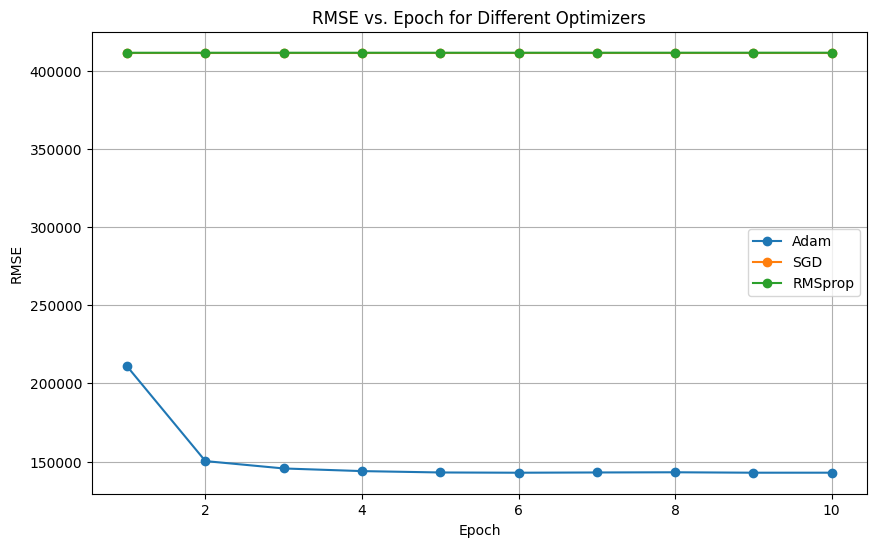

In [148]:
plt.figure(figsize=(10, 6))
for optimizer_name, rmse_list in rmse_values.items():
    plt.plot(range(1, epochs + 1), rmse_list, marker='o', label=optimizer_name)

plt.title('RMSE vs. Epoch for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()